In [10]:
%matplotlib inline

import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.optimize import curve_fit

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 11,9

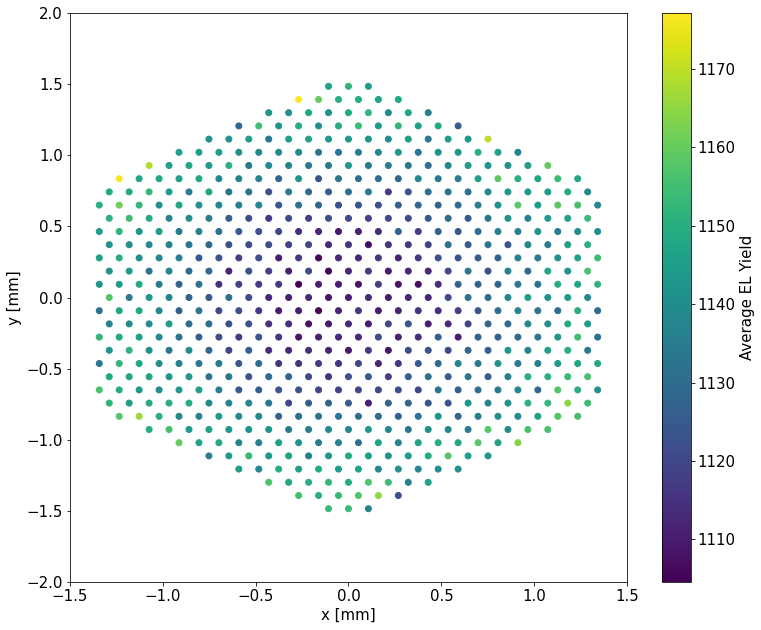

,q,r,excitation
423,-0.653061,0.285714,1150.826087
424,-0.653061,0.326531,1148.272727
425,-0.653061,0.367347,1176.416667
470,-0.612245,0.204082,1144.850000
471,-0.612245,0.244898,1150.775000
...,...,...,...
1929,0.612245,-0.244898,1156.298246
1930,0.612245,-0.204082,1147.722222
1975,0.653061,-0.367347,1155.700000
1976,0.653061,-0.326531,1154.275000


In [347]:
# Load in the unit cell and create map
# unitcell = pd.read_hdf("../Files/unitcell_Shifted.h5","Yields")
unitcell = pd.read_hdf("../Files/unitcell_Aligned.h5","Yields")

# Plot the loaded in unitcell
plt.figure()
sc = plt.scatter(unitcell["x"], unitcell["y"], c=unitcell["excitation"])
plt.colorbar(sc, label='Average EL Yield')
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.xlim(-1.5, 1.5)
plt.ylim(-2., 2.)
plt.tight_layout() 
plt.show()


unitcell = unitcell.drop(columns = ["x", "y"])
unitcell['q'] = unitcell['q'].astype(float)
unitcell['r'] = unitcell['r'].astype(float)
unitcell['excitation'] = unitcell['excitation'].astype(float)
display(unitcell)

In [348]:
# Load in the input file

mode = "kr"


if (mode == "kr"):
    input_file = "/Users/mistryk2/Packages/nexus//NEW.eminus_40keV.next.h5"
else:
    input_file = "/Users/mistryk2/Packages/nexus//NEW.eminus.next.h5"

## True hits (deposited energy)
hits = pd.read_hdf(input_file, 'MC/hits')
hits = hits[hits["label"] == "ACTIVE"]
hits = hits.drop(columns = ["label", "hit_id", "time", "particle_id"])

# Replace nan to zeros
hits['energy'] = hits['energy'].fillna(0)

In [349]:
# Calculate the total energy of each hit
hitsum = hits
hitsum = hitsum.drop(columns = ["x", "y", "z"])
hitsum['Esum'] = hitsum.groupby(["event_id"])["energy"].transform('sum')
hitsum = hitsum.drop(columns = ["energy"])
hitsum = hitsum.drop_duplicates()

if (mode == "bb"):
    # Get a list of events who do not deposit all their energy in the detector
    bad_events = hitsum[hitsum["Esum"] != 2.458].event_id.values

    # Filter the main hit list from the bad events
    hits = hits[~hits.event_id.isin(bad_events)]

    # Filter the event number
    hits = hits[hits["event_id"] < 50]

# Change the units of energy to eV
hits["energy"] = hits["energy"]*1e6
hits["ni"] = hits["energy"]/22.0
hits["ni"] = hits["ni"].round()

# Calculate the transverse diffusion sigma
D_T = 1.07 # mm/cm^0.5
hits["sigma"] = np.sqrt(hits["z"] * 0.1) * D_T # [mm]
print(hits["sigma"].max())
print(hits["sigma"].min())

print("z:", hits["z"].max())
print("z:", hits["z"].min())

print("x:", hits["x"].max())
print("x:", hits["x"].min())

print("y:", hits["y"].max())
print("y:", hits["y"].min())

print(hits["ni"].sum())

# Get rid of hits that do not have any energy deposits
hits = hits[hits["ni"] != 0]

# Drop the energy and z columns
hits = hits.drop(columns = ["z", "energy"])

display(hits)


7.792184352874756
0.2822325527667999
z: 530.3356323242188
z: 0.6957394480705261
x: 207.70004272460938
x: -205.2771759033203
y: 201.63047790527344
y: -205.78631591796875
1786267.0


,event_id,x,y,ni,sigma
0,0,30.756382,150.425232,12.0,7.676002
1,0,30.762486,150.432251,650.0,7.675452
2,0,30.792227,150.441452,172.0,7.675306
3,0,30.797560,150.416000,182.0,7.675215
4,0,30.777555,150.409531,264.0,7.675211
...,...,...,...,...,...
12044,999,105.786980,110.613274,279.0,3.496478
12045,999,105.783089,110.607460,85.0,3.496467
12046,999,105.786491,110.605331,59.0,3.496511
12047,999,105.784134,110.603790,135.0,3.496478


In [350]:
# Transform x, y positions to unit cell positions
hexsize = (1.25+0.127/2.0)/(np.cos(30*np.pi/180))
print(hexsize)

# Define bins in q and r space
numbins = 50

bins_q, bw_q  = np.linspace(-1, +1, numbins, retstep=True)
bins_centre_q = np.linspace(-1+bw_q/2, 1+bw_q/2, numbins)[:-1]

bins_r, bw_r  = np.linspace(-1, +1, numbins, retstep=True)
bins_centre_r = np.linspace(-1+bw_r/2, 1+bw_r/2, numbins)[:-1]

# Calculate the nearest hexagon centre to the point
def hex_round(q,r,s,mode):
    qi = int(round(q))
    ri = int(round(r))
    si = int(round(s))
    q_diff = abs(qi - q)
    r_diff = abs(ri - r)
    s_diff = abs(si - s)
    
    if q_diff > r_diff and q_diff > s_diff:
        qi = -ri - si
    else:
        if r_diff > s_diff:
            ri = -qi - si
        else:
            si = -qi - ri
    
    if (mode == "q"):
        return qi
    elif (mode == "r"):
        return ri
    else:
        return si


def GetHexCoords(df):
    # Calculate q and r values for hits table
    df["q"] = (df["x"] * np.sqrt(3)/3.0 - 1.0/3.0*df["y"]) / hexsize 
    df["r"] = (2.0/3.0)*df["y"] / hexsize
    df["s"] = -df["q"] - df["r"]

    # Calculate the multiple of q and r of the hexagon ~ 50 s
    df["nq"] = df.apply(lambda df_: hex_round(df_["q"], df_["r"], df_["s"], "q"), axis = "columns", result_type='expand' )
    df["nr"] = df.apply(lambda df_: hex_round(df_["q"], df_["r"], df_["s"], "r"), axis = "columns", result_type='expand' )

    # Shift the values to unit cell
    df["q"] = df["q"] - df["nq"]
    df["r"] = df["r"] - df["nr"]

    # Drop columns that are now not needed
    df = df.drop(columns = ["s", "nq","nr", "x", "y"])

    # Now bin the data ~20s
    df['q'] = pd.cut(x=df['q'], bins=bins_q,labels=bins_centre_q, include_lowest=True)
    df['r'] = pd.cut(x=df['r'], bins=bins_r,labels=bins_centre_r, include_lowest=True)
    return df

1.5166991571611466


In [351]:
rng = np.random.default_rng()

evid = -1

Yieldsum = 0

Yields = []

for ev,x,y,ni,sigma in zip(hits["event_id"], hits["x"], hits["y"], hits["ni"], hits["sigma"]):

    temp_df = pd.DataFrame()

    if (evid != ev):

        if (Yieldsum != 0):
            print("Yield: ",Yieldsum)
            Yields.append(Yieldsum)

        Yieldsum = 0
        evid = ev

        # if(ev % 10 == 0):
        print(ev)
    
    # Calculate smeared position for each electron
    mean = (x, y)
    cov = [[sigma, 0], [0, sigma]]
    x_samp, y_samp = rng.multivariate_normal(mean, cov, int(ni)).T

    # Create a dataframe and bin the x and y sample
    temp_df["x"] = x_samp
    temp_df["y"] = y_samp

    # Transform the sampled x,y position to a binned q,r position in the hexagon unit cell
    temp_df = GetHexCoords(temp_df)
    
    Yieldsum += pd.merge(temp_df, unitcell, how ='inner', on =['q', 'r']).excitation.sum()
    # print(Yieldsum)


0
Yield:  2061668.663348382
1
Yield:  2062330.6732031833
2
Yield:  2059275.1438467784
3
Yield:  2059726.4753559614
4
Yield:  2062636.6793941052
5
Yield:  2063915.06290039
6
Yield:  2060241.4812623898
7
Yield:  2061286.0257098034
8
Yield:  2061177.5617174278
9
Yield:  2060788.7285623609
10
Yield:  2062772.1763836185
11
Yield:  2060931.5733526119
12
Yield:  2061902.0813291178
13
Yield:  2059037.830663221
14
Yield:  2059402.4180202426
15
Yield:  2059586.4730528737
16
Yield:  2060357.150040818
17
Yield:  2061055.0877214426
18
Yield:  2060540.4700376093
19
Yield:  2061338.6185151897
20
Yield:  2059952.851842435
21
Yield:  2064021.7167043677
22
Yield:  2061476.348093445
23
Yield:  2061150.6871820327
24
Yield:  2059853.6528219585
25
Yield:  2060643.8303842458
26
Yield:  2058695.430064882
27
Yield:  2058972.4600298975
28
Yield:  2059384.6618279598
29
Yield:  2062685.2431752305
30
Yield:  2062550.9113168176
31
Yield:  2062852.6340769609
32
Yield:  2058676.3159279886
33
Yield:  2058826.762659219

[4.14998937e+02 2.06116258e+00 1.34165429e-03]
Resolution =  0.15296646782816942


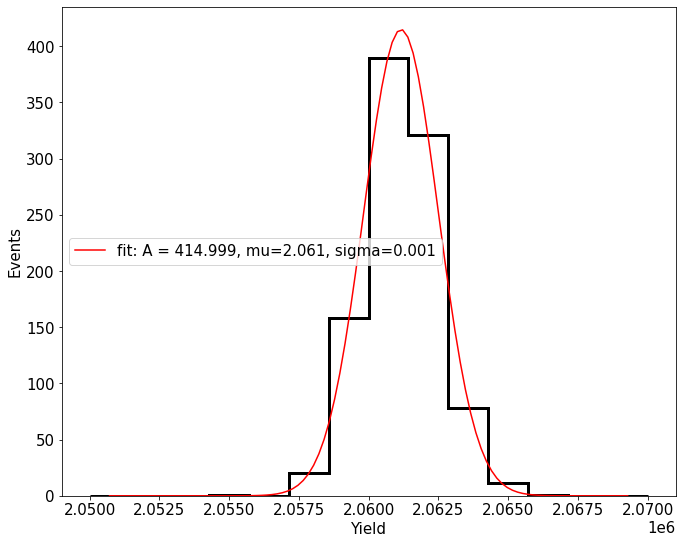

In [352]:
# Make a histogram of the total photon yeilds
plt.figure()

if (mode == "kr"):
    # bins_x = np.linspace(2.21e6, 2.23e6, 15)
    bins_x = np.linspace(2.05e6, 2.07e6, 15)
    scale = 1e6
else:
    bins_x = np.linspace(1.365e8, 1.366e8, 15)
    scale = 1e8

counts, xbins, _ = plt.hist(Yields, bins = bins_x, histtype="step", color = "black", linewidth=3)
# plt.xlim(-200, 6200)
plt.xlabel("Yield")
plt.ylabel("Events")

xbins/=scale

# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

bin_centers = xbins+ (xbins[1]-xbins[0])/2.0
bin_centers = bin_centers[:-1]

popt, pcov = curve_fit(Gaussian_, bin_centers, counts)
print(popt)

plt.plot(np.linspace(min(bin_centers)*scale, max(bin_centers)*scale, 100), Gaussian_(np.linspace(min(bin_centers), max(bin_centers), 100), *popt), 'r-',label='fit: A = %5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
print("Resolution = ",100* 2.35*popt[2]/popt[1] )
plt.legend()
plt.show()
